Freq_domain_meas
=================

### **[Cavity search](#Cavity-search)** 
Search the location of the cavity with $sweeping$ $LO$ $frequency$ due to large frequency range (e.g. $5.0$ - $7.0$ GHz)

(Frequency range needs to be a `float` number

### **[Power dependent cavity](#Power-dependent-cavity)** 
Search the location of the dress state cavity with $sweeping$ $NCO$ $frequency$ due to small frequency range (e.g. $6.0$ - $6.02$ GHz)



To run this, you will need:
* [QRM-RF](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/cluster/qcm_rf.html)
* Device under test: a Superconducting Qubit
* Two SMA-cables
* Installation and enabling of ipywidgets


Setup
-----

In [53]:
# Import ipython widgets
import json
import math
import os
from typing import List

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

# Set up the environment
import scipy.signal
from IPython.display import display

from ipywidgets import fixed, interact, interact_manual, interactive
from qcodes import Instrument

from qblox_instruments import Cluster, PlugAndPlay

#### Scan for device

In [54]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()

names = {dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()}
ip_addresses = {dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[
        (names[dev_id] + " @" + ip_addresses[dev_id], dev_id) for dev_id in device_list.keys()
    ],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('cluster-mm @192.168.1.171', '00015_2406_014'), ('Marketing-Cl…

#### Connect to Cluster

In [55]:
# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.
try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

cluster = Cluster(name=names[dev_id], identifier=ip_addresses[dev_id])

print(f"{connect.label} connected")
print(cluster.get_system_state())

/Users/ratiswu/miniforge3/envs/qblox/lib/python3.9/site-packages/qcodes/instrument/instrument_base.py:543: UserWarning: Changed Marketing-Cluster to Marketing_Cluster for instrument identifier
  warnings.warn(f"Changed {name} to {new_name} for instrument identifier")


Marketing-Cluster @192.168.1.170 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


In [56]:
def select_module_widget(
    device, select_all=False, select_qrm_type: bool = True, select_rf_type: bool = False
):
    """Create a widget to select modules of a certain type

    default is to show only QRM baseband

    Args:
        devices : Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_qrm_type (bool): filter QRM/QCM
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]

    for module in device.modules:
        if module.present():
            if select_all or (
                module.is_qrm_type == select_qrm_type and module.is_rf_type == select_rf_type
            ):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [57]:
print("Select the readout module from the available modules:")
select_readout_module = select_module_widget(cluster, select_qrm_type=True, select_rf_type=True)

Select the readout module from the available modules:


Dropdown(options=([None, None], ['Marketing_Cluster module8 (QRM_RF)', <QcmQrm: Marketing_Cluster_module8 of C…

In [58]:
readout_module = select_readout_module.value
print(f"{readout_module} connected")

<QcmQrm: Marketing_Cluster_module8 of Cluster: Marketing_Cluster> connected


#### Reset the cluster

In [59]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE


In [60]:
# Plotting function& Cav freq locating
def plot_spectrum(start_freq, stop_freq, num_data, freq_sweep_range, I_data, Q_data):
    amplitude = np.sqrt(I_data**2 + Q_data**2)
    phase = np.arctan2(Q_data, I_data) * 180 / np.pi

    mean_amp = np.mean(amplitude)
    print(mean_amp)

    plt.rcParams["axes.labelsize"] = 18
    plt.rcParams["xtick.labelsize"] = 16
    plt.rcParams["ytick.labelsize"] = 16

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(15, 7))

    cav_freq = scipy.signal.argrelmin(amplitude, order = round(num_data/8))
    cav_freq = cav_freq[0]
    for i in cav_freq:
        if amplitude[i] > mean_amp*2/3:        # Discard the local minimum which is caused by noise
            cav_freq = np.delete(cav_freq, np.where(cav_freq == i))

    ax1.plot(freq_sweep_range / 1e9, amplitude, color="#00839F", linewidth=2)
    ax1.plot(((cav_freq / num_data)*(stop_freq - start_freq) + start_freq) /1e9, amplitude[cav_freq], "x")
    print(((cav_freq / num_data)*(stop_freq - start_freq) + start_freq) /1e9)
    ax1.set_ylabel("Amplitude (V)")

    ax2.plot(freq_sweep_range / 1e9, phase, color="#00839F", linewidth=2)
    ax2.set_ylabel("Phase ($\circ$)")
    ax2.set_xlabel("Frequency (GHz)")
    fig.tight_layout()
    plt.show()

Cavity search
-------------

Sweeping LO frequency to get the location frequency of all cavities, the frequency you get will be the $bare$ $state$ $frequency$.

In [64]:
# Parameters
num_averages = 10
integration_length = 1024
holdoff_length = 200
waveform_length = integration_length + holdoff_length

lo_start_freq = 5.2e9
lo_stop_freq = 5.7e9
num_data = 501
nco_freq = 1e6

In [62]:
# Acquisitions
acquisitions = {"acq": {"num_bins": 1, "index": 0}}

In [65]:
# Sequence program
seq_prog = f"""
      move    {num_averages},R0           # Average iterator.
      nop
      reset_ph
      set_awg_offs 10000, 10000          # set amplitude of signal
      nop
loop: 
      wait     {holdoff_length}          # Wait time of flight
      acquire  0,0,{integration_length}  # Acquire data and store them in bin_n0 of acq_index.
      loop     R0,@loop                  # Run until number of average iterations is done.
      stop                               # Stop the sequencer
      """

# Add sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": {},
    "weights": {},
    "acquisitions": acquisitions,
    "program": seq_prog,
}
with open("sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Upload sequence
readout_module.sequencer0.sequence("sequence.json")

In [66]:
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

# Configure channel map
readout_module.sequencer0.connect_sequencer("io0")

readout_module.sequencer0.marker_ovr_en(True)
readout_module.sequencer0.marker_ovr_value(3)  # Enables output on QRM-RF

# Set offset in mV
readout_module.out0_offset_path0(5.5)
readout_module.out0_offset_path1(5.5)

# Configure scope mode
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer
readout_module.sequencer0.mod_en_awg(True)
readout_module.sequencer0.demod_en_acq(True)
readout_module.sequencer0.nco_freq(nco_freq)
readout_module.sequencer0.integration_length_acq(integration_length)
readout_module.sequencer0.sync_en(True)

# NCO delay compensation
readout_module.sequencer0.nco_prop_delay_comp_en(True)

#### Start measurement

In [67]:
lo_sweep_range = np.linspace(lo_start_freq, lo_stop_freq, num_data)

lo_data_0 = []
lo_data_1 = []

for lo_val in lo_sweep_range:
    # Update the LO frequency.
    readout_module.out0_in0_lo_freq(lo_val)

    # Clear acquisitions
    readout_module.sequencer0.delete_acquisition_data("acq")

    readout_module.arm_sequencer(0)
    readout_module.start_sequencer()

    # Wait for the sequencer to stop with a timeout period of one minute.
    readout_module.get_acquisition_state(0, timeout=1)

    # Move acquisition data from temporary memory to acquisition list.
    readout_module.store_scope_acquisition(0, "acq")

    # Get acquisition list from instrument.
    data = readout_module.get_acquisitions(0)["acq"]

    # Store the acquisition data.
    # The result still needs to be divided by the integration length to make sure
    # the units are correct.
    lo_data_0.append(data["acquisition"]["bins"]["integration"]["path0"][0] / integration_length)
    lo_data_1.append(data["acquisition"]["bins"]["integration"]["path1"][0] / integration_length)

# Change data type
lo_data_0 = np.asarray(lo_data_0)
lo_data_1 = np.asarray(lo_data_1)

0.058725270897580915
[5.35968263 5.44950299 5.52734731 5.63612974]


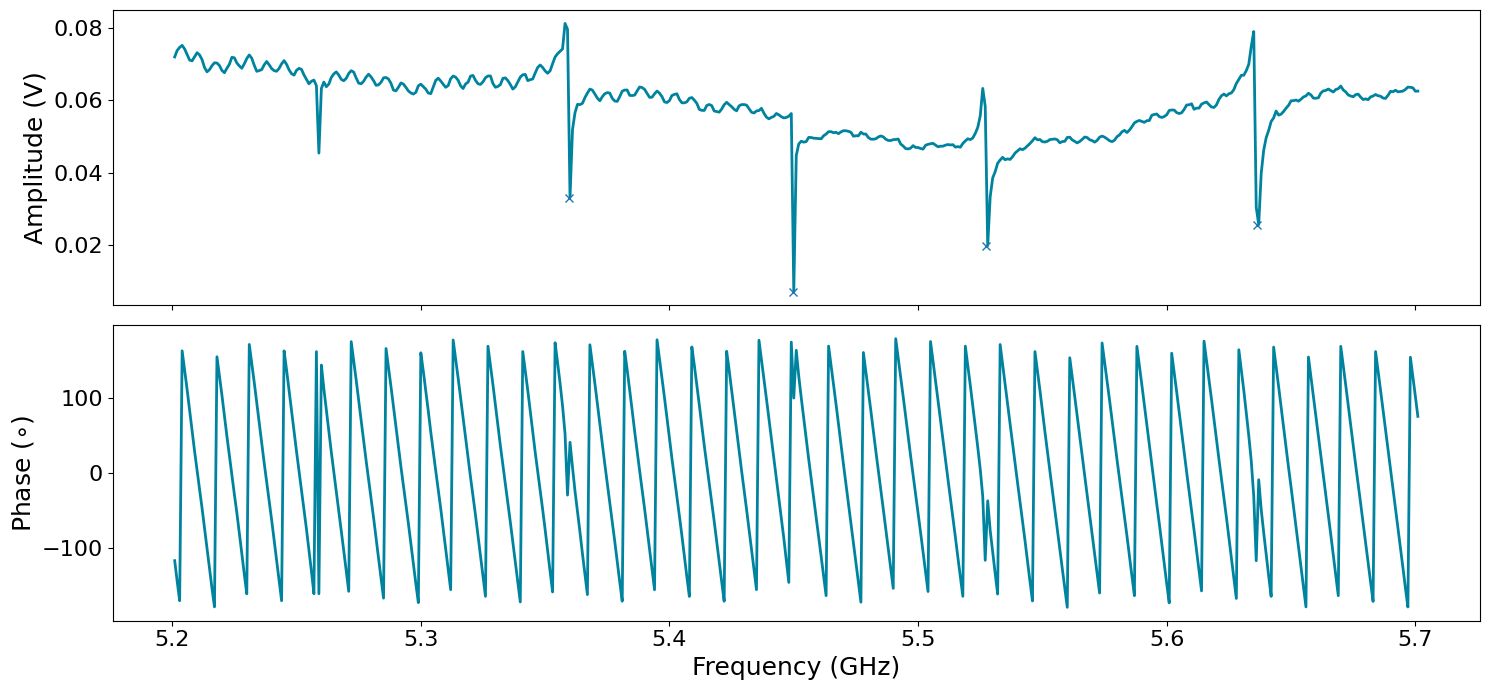

In [68]:
# Plot amplitude/phase results
plot_spectrum(lo_start_freq + nco_freq, lo_stop_freq + nco_freq, num_data, lo_sweep_range + nco_freq, lo_data_0, lo_data_1)

In [18]:
from qcodes import Instrument
cluster.reset() 
Instrument.close_all() 